In [85]:
# Dataframe
import pandas as pd

# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# Math
import numpy as np

# Prepping for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

# Modeling
from sklearn.ensemble import RandomForestClassifier

# Metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import accuracy_score

# For interactive confusion matrix
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from ipywidgets import interactive, FloatSlider

# Tuning Hyperparameters
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

In [86]:
df_train = pd.read_csv('pre_processed_train_tree.csv')
df_test = pd.read_csv('pre_processed_test_tree.csv')

In [87]:
df_train.head()

,Unnamed: 0,amount_tsh,gps_height,longitude,latitude,basin,region,population,public_meeting,scheme_management,permit,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity,source_type,waterpoint_type_group,status_group
0,0,6000.0,1390,34.938093,-9.856322,1,3,109,1,7,0,5,0,4,0,2,1,6,1,3
1,2,25.0,686,37.460664,-3.821329,5,8,250,1,7,1,3,0,4,5,2,1,1,1,3
2,3,0.0,263,38.486161,-11.155298,7,12,58,1,7,1,2,5,4,2,2,0,0,1,1
3,5,20.0,0,39.172796,-4.765587,5,20,1,1,7,1,3,5,4,5,4,1,2,1,3
4,6,0.0,0,33.362410,-3.766365,0,17,0,1,7,1,5,1,4,2,2,1,0,3,1


In [88]:
# Drop unnecessary columns
df_train.drop(columns='Unnamed: 0', inplace = True)
df_test.drop(columns='Unnamed: 0', inplace = True)

In [89]:
# 1 represents non-functional or needs repair water pumps. 0 represents functional water pumps.
def change_target(row):
    if row['status_group'] == 3:
        return 0
    else:
        return 1
    
df_train['status_group'] = df_train.apply(lambda row: change_target(row), axis = 1)
df_test['status_group'] = df_test.apply(lambda row: change_target(row), axis = 1)

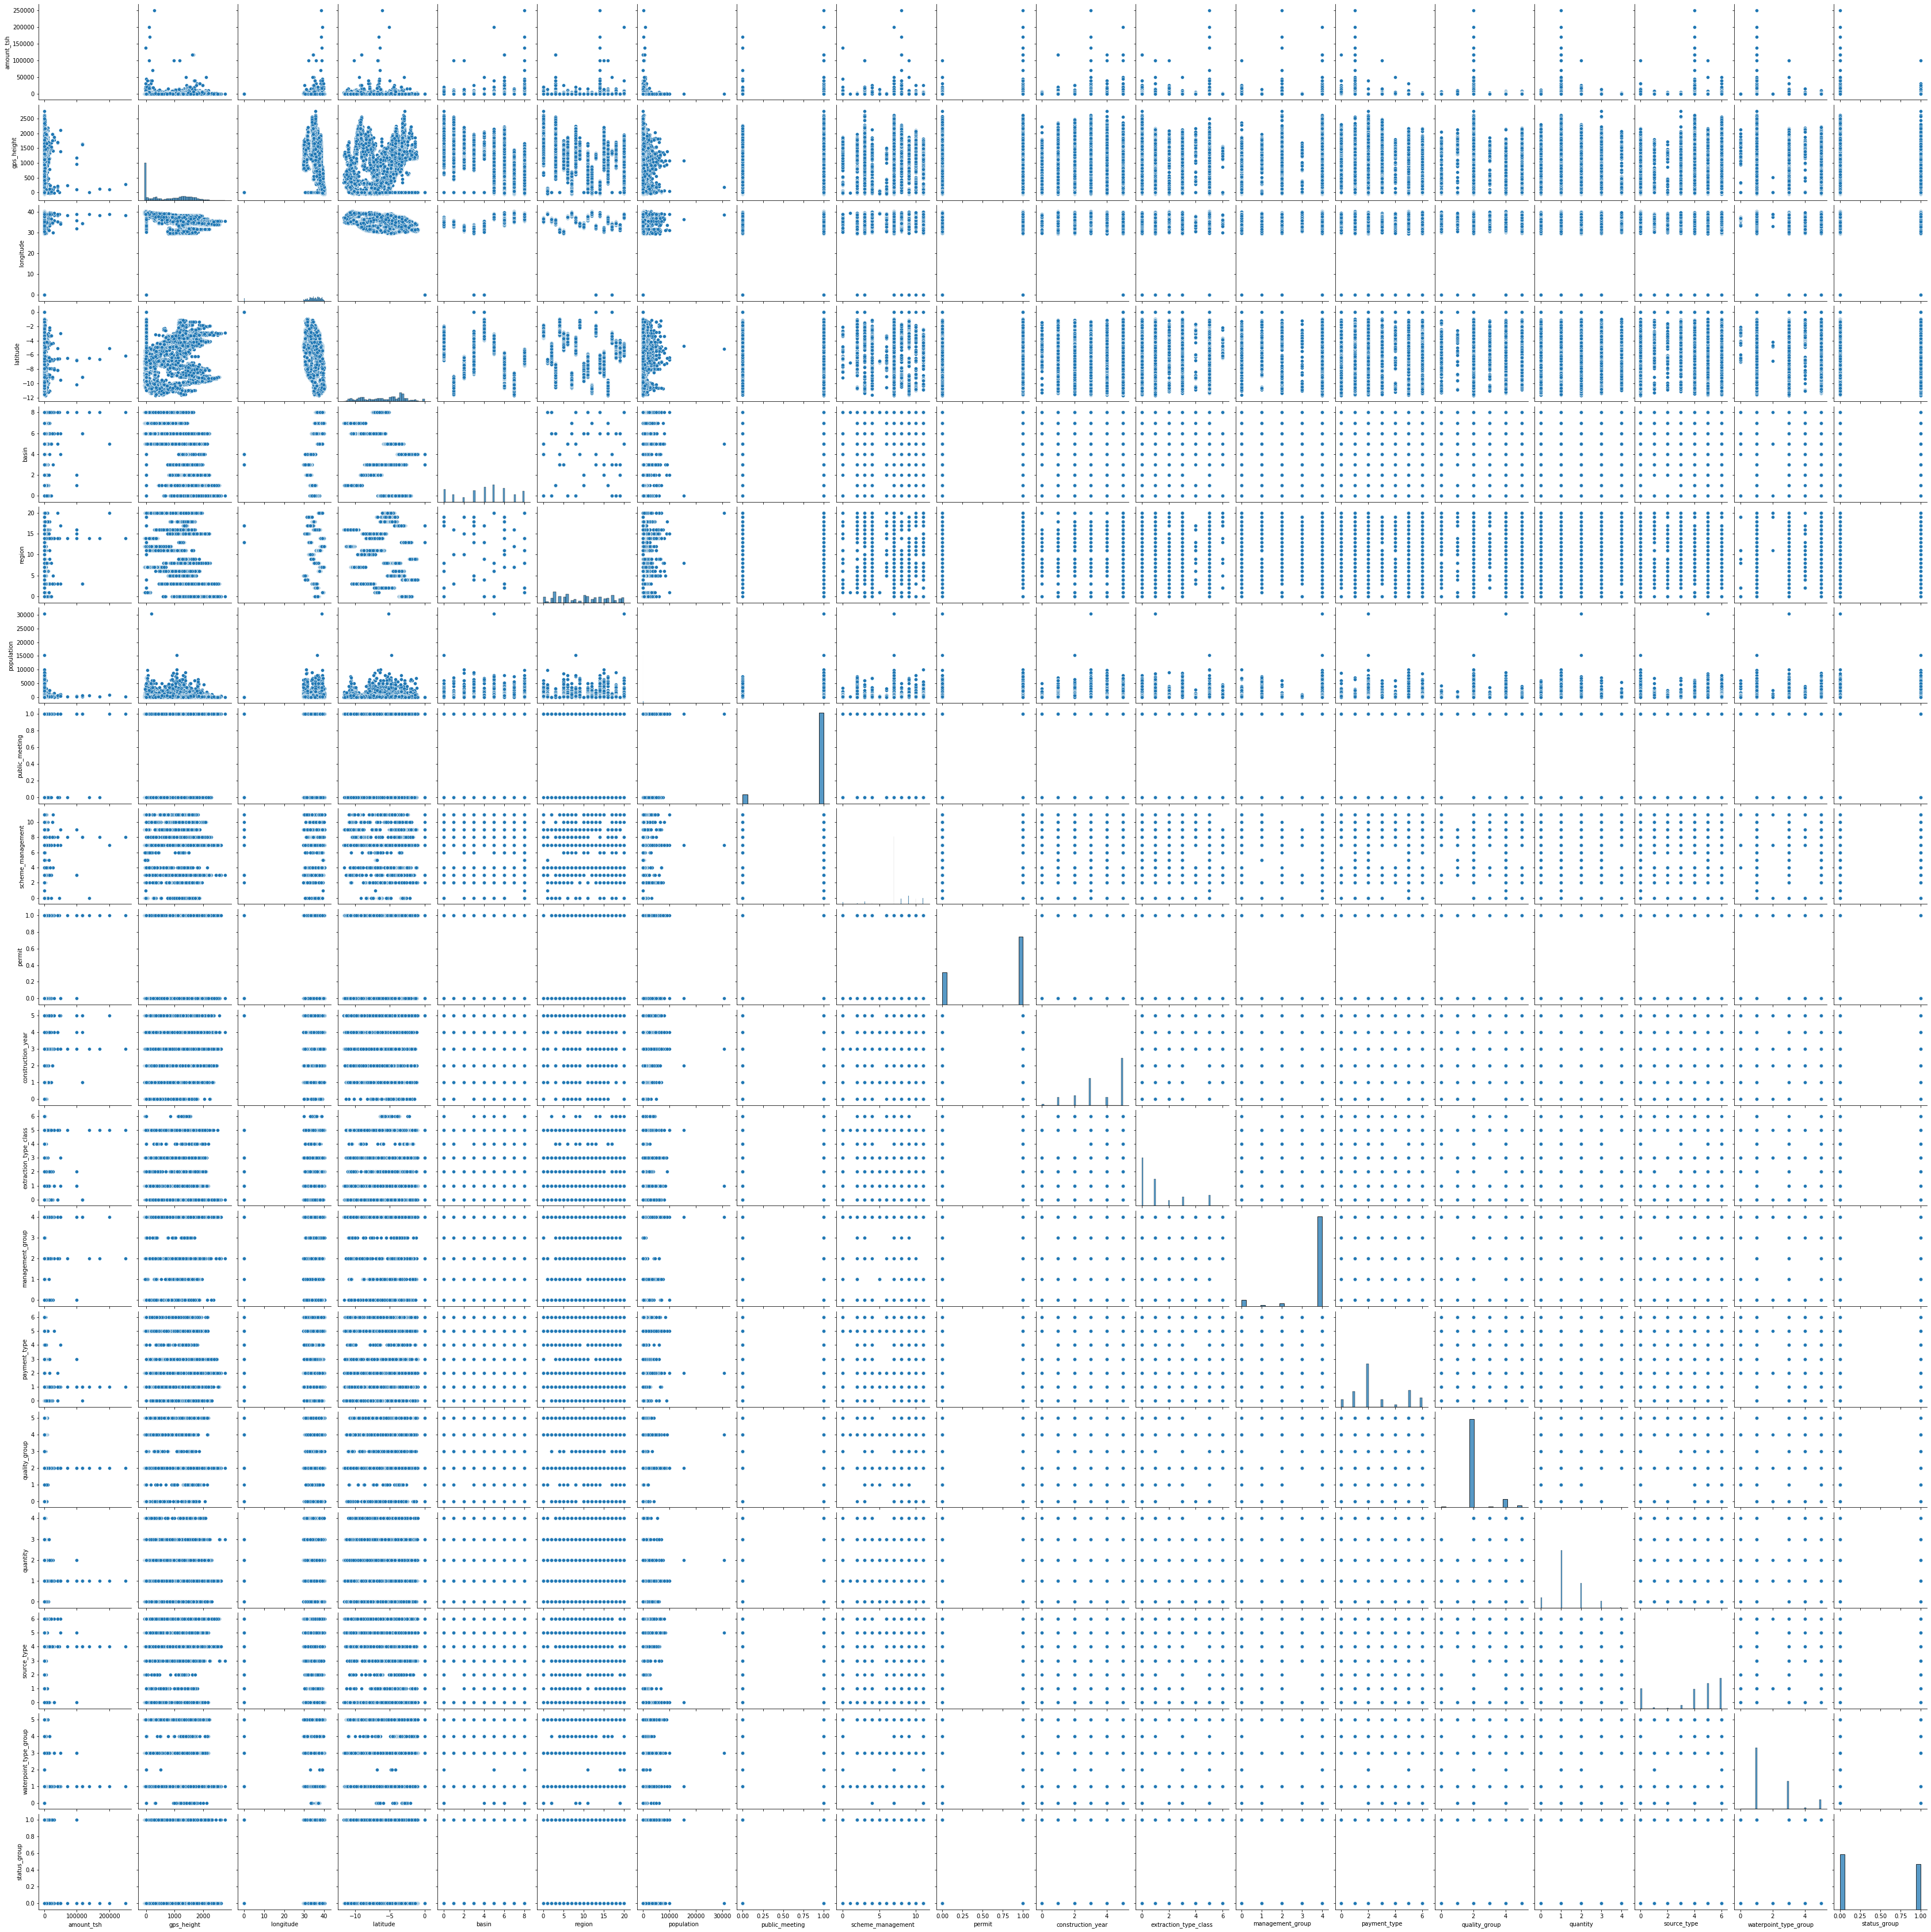

In [35]:
sns.pairplot(df_train)

In [ ]:
sns.pairplot(df_train.drop(columns='status_group'), hue = 'status_group')

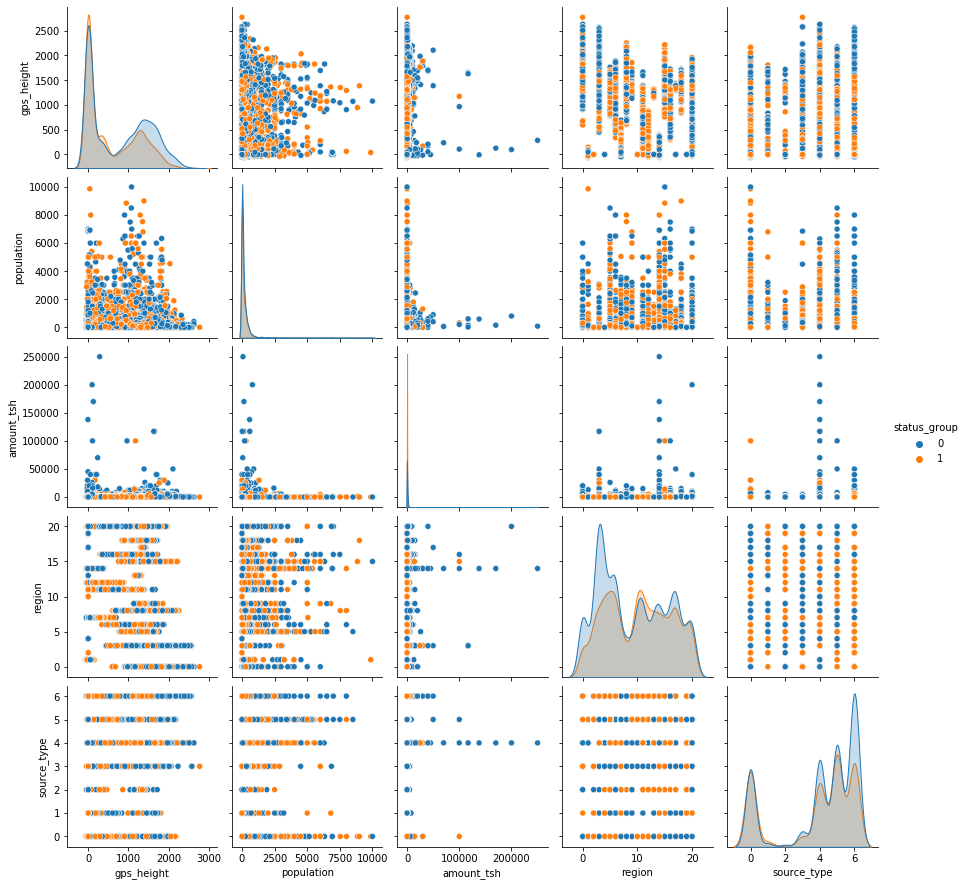

In [106]:
sns.pairplot(df_train[['gps_height', 'population', 'status_group', 'amount_tsh', 'region', 'source_type']], hue = 'status_group')

Not great separation for any of these.

In [90]:
#Get rid of population outliers
df_train = df_train[~(df_train.population > 12000)]
df_test = df_test[~(df_test.population > 12000)]

# Training the Model

In [91]:
X = df_train.drop(columns=['status_group', 'latitude', 'longitude'])
y = df_train['status_group']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [93]:
#Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) # Scale test features

In [94]:
#Create classifier
clf=RandomForestClassifier(n_estimators=100)

#Train model
clf.fit(X_train,y_train)

#Predict y values for test set
y_pred=clf.predict(X_test)

# Evaluation with Various Metrics

In [68]:
def make_confusion_matrix(model, threshold=.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    fig, ax = plt.subplots(figsize=(8,6))
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    functional_confusion = confusion_matrix(y_test, y_predict)

    #Print the sns map
    group_names = ['True Neg','False Po','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
            functional_confusion.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
            functional_confusion.flatten()/np.sum(functional_confusion)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    xlabels = ['functional', 'non-functional']
    ylabels = ['functional', 'non-functional']
    sns.heatmap(functional_confusion, annot=labels, fmt='', cmap='Blues', 
                xticklabels=xlabels, yticklabels=ylabels)
    ax.set_ylim([2,0])
    plt.xlabel('prediction')
    plt.ylabel('actual')
    
    #Princt various scores/metrics
    print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test, y_predict), 
                                                     recall_score(y_test, y_predict)))
    print("F1 Score: ", f1_score(y_test, y_predict))
    print("ROC AUC score : ", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
    
    print("Accuracy score: ", accuracy_score(y_test, y_predict))
    
    print('Training accuracy:', model.score(X_train, y_train))
    print('Test accuracy:', model.score(X_test, y_test))

In [34]:
# Print confusion matrix and various metrics
interactive(lambda threshold: make_confusion_matrix(clf, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

## ROC Plot

Logistic: ROC AUC=0.876


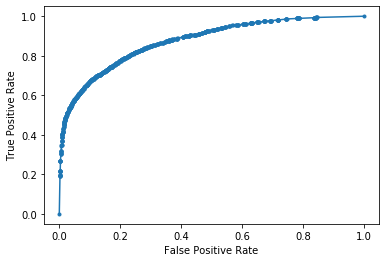

In [35]:
# Predict probabilities
clf_probs = clf.predict_proba(X_test)

# keep probabilities for the positive outcome only
clf_probs = clf_probs[:, 1]

# calculate score
clf_auc = roc_auc_score(y_test, clf_probs)

# print score
print('Logistic: ROC AUC=%.3f' % (clf_auc))

# calculate ROC curve
clf_fpr, clf_tpr, _ = roc_curve(y_test, clf_probs)

# plot the ROC curve
plt.plot(clf_fpr, clf_tpr, marker='.', label='Logistic')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

# Feature Importance

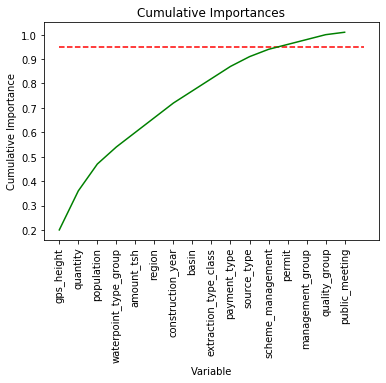

In [16]:
feature_list = X.columns

importances = list(clf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
x_values = list(range(len(importances)))

#Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

In [36]:
# Make a sorted list of features and their importance values
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


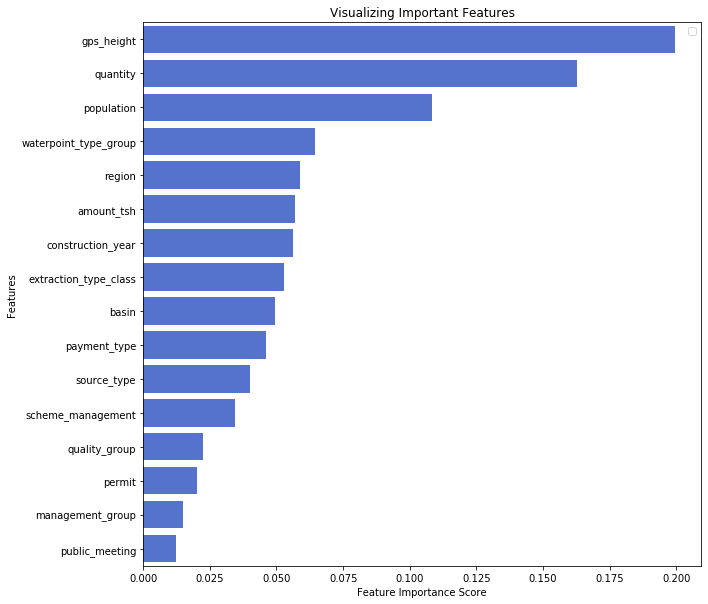

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index, color='royalblue')
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# Tuning Parameters

In [154]:
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [155]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [42]:
# Apply RandomizedSearchCV with specified grid.
clf2 = RandomForestClassifier()
clf_random = RandomizedSearchCV(estimator = clf2, param_distributions = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]},
                               n_iter = 100, cv = 3, random_state = 42, n_jobs = -1)

clf_random.fit(X_train, y_train)

KeyboardInterrupt: 

In [158]:
# Print the best parameters
clf_random.best_params_

{'n_estimators': 1800,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 60,
 'bootstrap': True}

# Model with best parameters

In [69]:
#Create classifier
clf=RandomForestClassifier(n_estimators=1800, min_samples_split=5, 
                           min_samples_leaf=2, max_features='sqrt',
                           max_depth=60, bootstrap=True)

#Train model
clf.fit(X_train,y_train)

#Predict y values for test set
y_pred=clf.predict(X_test)

In [70]:
#Print confusion matrix and various metric scores
interactive(lambda threshold: make_confusion_matrix(clf, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [71]:
# Make a series with features and their importance values
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


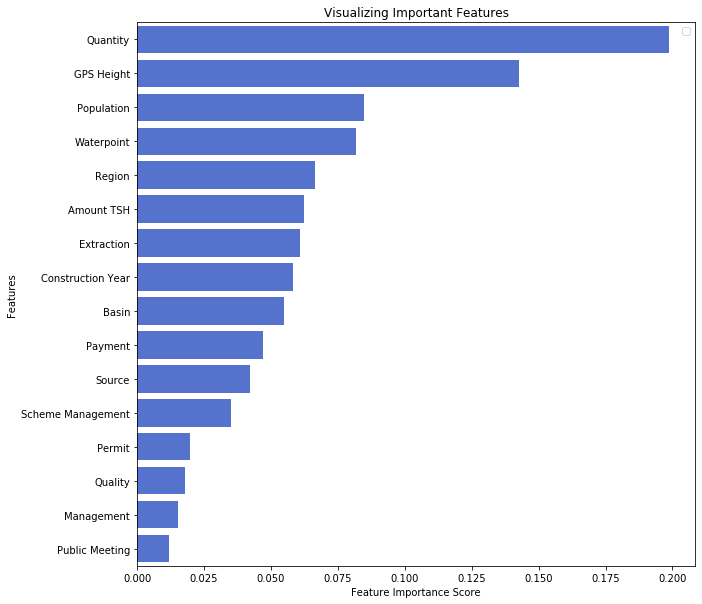

In [84]:
# List to make feature names readable and not in their variable name format
features = ['Quantity', 'GPS Height', 'Population', 'Waterpoint', 'Region', 'Amount TSH',
           'Extraction', 'Construction Year', 'Basin', 'Payment', 'Source',
           'Scheme Management', 'Permit', 'Quality', 'Management', 'Public Meeting']

fig, ax = plt.subplots(figsize=(10, 10))
# Creating a bar plot
sns.barplot(x=feature_imp, y=features, color='royalblue')
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# Test

In [81]:
X = df_test.drop(columns=['status_group', 'latitude', 'longitude'])
y = df_test['status_group']

In [82]:
y_predict = (clf.predict_proba(X)[:, 1] >= .4) #threshold=.4

print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y, y_predict), 
                                                     recall_score(y, y_predict)))
print("F1 Score: ", f1_score(y, y_predict))
print("ROC AUC score : ", roc_auc_score(y, clf.predict_proba(X)[:,1]))
    
print("Accuracy score: ", accuracy_score(y, y_predict))

Precision: 0.7498,   Recall: 0.8098
F1 Score:  0.7786522911051212
ROC AUC score :  0.8834068063916533
Accuracy score:  0.7939995986353602
